In [360]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 31.2 ms


In [361]:
import os
import cv2
import sys
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F

from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as fnn
from torchvision import transforms

root_path = './'
sys.path.append(root_path)

from hack_utils import Timer
from hack_utils import NUM_PTS
from hack_utils import ThousandLandmarksDataset, DebugThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

time: 32.6 ms


# Реализуем вспомогательные функции

Обучение модели

In [414]:
class ENMELoss:
    def __init__(self, alpha=2.0):
        self.alpha = torch.tensor(alpha, dtype=torch.float32, requires_grad=False)
    
    def __call__(self, input_t, target_t):
        """
        Args:
            input_t: (batch_size, 2*NUM_PTS)
            target_t: (batch_size, 2*NUM_PTS)
            
        Return:
            losses: (batch_size, )
        """
        delta_p = self._nme(input_t, target_t)
        losses = self._le(delta_p)
        return losses
        
    def _nme(self, input_t, target_t):
        input_points = input_t.view(-1, NUM_PTS, 2)
        target_points = target_t.view(-1, NUM_PTS, 2)
        
        square_coord_deltas = (target_points - input_points)**2
        delta_p = torch.mean(torch.sqrt(square_coord_deltas.sum(dim=2)), dim=1)
        
        return delta_p
    
    def _le(self, delta_p):
        le = (self.alpha + 1) * delta_p - self.alpha * torch.log((torch.exp(delta_p) + torch.exp(-delta_p)) / 2)
        return le

time: 29.5 ms


In [411]:
def train(model, loader, loss_fn, optimizer, device, epoch, writer, scheduler, bottom_k=12, 
          top_perc_train=25., without_top_perc_train=2.):
    model.train()
    train_loss = []
    train_mse_loss = []
    mse_loss_fn = nn.MSELoss()
    loss_id = []
    loader_len = len(loader)
    top_n_train = int(top_perc_train / 100 * train_params['batch_size']) + 1
    without_top_n_train = int(without_top_perc_train / 100 * train_params['batch_size'])
    
    for n_batch, batch in tqdm(enumerate(loader), total=loader_len, desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        
        train_mse_loss.append(mse_loss_fn(pred_landmarks, landmarks).item())
        writer.add_scalar('train_batch_mse_loss', train_mse_loss[-1], epoch*loader_len + n_batch)
        writer.add_scalar('train_batch/epoch_mse_loss', train_mse_loss[-1], float(epoch + n_batch / loader_len))
        
#         losses = torch.mean(loss_fn(pred_landmarks, landmarks), dim=1)
        losses = loss_fn(pred_landmarks, landmarks)
        loss_id.extend([(loss.item(), i) for i, loss in enumerate(losses, n_batch*train_params['batch_size'])])
        loss_id = sorted(loss_id)[-bottom_k:]
        
        sorted_losses, _ = torch.sort(losses, dim=0, descending=True)
        
        loss = torch.mean(sorted_losses[without_top_n_train:top_n_train])
        train_loss.append(loss.item())
        writer.add_scalar('train__batch_loss', train_loss[-1], epoch*loader_len + n_batch)
        writer.add_scalar('train_batch/epoch_loss', train_loss[-1], epoch + n_batch / loader_len)
        
        scheduler.step(train_loss[-1])
        writer.add_scalar('lr_batch', optimizer.state_dict()['param_groups'][0]['lr'], float(epoch*loader_len + n_batch))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_mse', np.mean(train_mse_loss), epoch)
    
    fig = worst_samples2figure(model, loader, device, loss_id_list=loss_id)
    writer.add_figure('train_worst_preds', fig, epoch)

    return np.mean(train_loss)

time: 28.3 ms


Валидация модели

In [412]:
def validate(model, loader, loss_fn, device, epoch, writer, bottom_k=12):
    model.eval()
    val_loss = []
    val_mse_loss = []
    mse_loss_fn = nn.MSELoss()
    loss_id = []
    loader_len = len(loader)
    
    for n_batch, batch in tqdm(enumerate(loader), total=loader_len, desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
            
        val_mse_loss.append(mse_loss_fn(pred_landmarks, landmarks).item())
#         losses = torch.mean(loss_fn(pred_landmarks, landmarks), dim=1)
        losses = loss_fn(pred_landmarks, landmarks)
        loss_id.extend([(loss.item(), i) for i, loss in enumerate(losses, n_batch*train_params['batch_size'])])
        loss_id = sorted(loss_id)[-bottom_k:]
        
        loss = torch.mean(losses)
        val_loss.append(loss.item())
    
    writer.add_scalar('val_mse', np.mean(val_mse_loss), epoch)
    
    fig = worst_samples2figure(model, loader, device, loss_id_list=loss_id)
    writer.add_figure('val_worst_preds', fig, epoch)

    return np.mean(val_loss)

time: 32.3 ms


Предсказание моделью

def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

Создание названия эксперимента

In [364]:
def get_exp_name(train_params: dict, name: str = None) -> str:
    cur_time = time.strftime("%b_%d_%Y_%H:%M:%S", time.localtime())
    exp_name = f"{cur_time}__"
    if name is not None:
        exp_name += f"{name}_"
    exp_name += f"model={train_params['base_model']}_bs={train_params['batch_size']}_"\
        f"epochs={train_params['epochs']}_lr={train_params['lr']}_"\
        f"lr_decay={train_params['lr_decay']}_w_decay={train_params['weight_decay']}_"\
        f"top_prec={train_params['top_perc_train']}_without_top_perc={train_params['without_top_perc_train']}"
    return exp_name

time: 30.7 ms


Отрисовка предсказаний

In [365]:
from typing import List, Dict, Any, Tuple

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)


def tensor_image2numpy(image: torch.Tensor) -> np.ndarray:
    # revert normalization
    image = (image * std) + mean
    
    return np.array(F.to_pil_image(image))


def draw_landmarks(image: np.ndarray, landmarks: np.ndarray) -> np.ndarray:
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)

    return image


def figure_landmark_examples(images: torch.Tensor, landmarks: torch.Tensor, landmarks2=None, titles=None):
    n_images = images.shape[0]
    if landmarks2 is not None:
        n_images *= 2
        
    n_cols = 4
    n_rows = n_images // n_cols + int(n_images % n_cols != 0)

    fig = plt.figure(figsize=(25, n_rows * 8))
    j = 1
    for i, (image, landmark) in enumerate(zip(images, landmarks)):
        image = tensor_image2numpy(image)
        landmark = np.array(landmark.reshape(NUM_PTS, 2))
        
        new_image = draw_landmarks(image.copy(), landmark)

        ax = fig.add_subplot(n_rows, n_cols, j)
        ax.imshow(new_image)
        if titles is not None:
            ax.set_title(titles[i])
        j += 1
        
        if landmarks2 is not None:
            landmark = np.array(landmarks2[i].reshape(NUM_PTS, 2))
            new_image = draw_landmarks(image, landmark)

            ax = fig.add_subplot(n_rows, n_cols, j)
            ax.imshow(new_image)
            j += 1

    return fig


def figure_by_samples(samples: List[Dict[str, Any]]):
    n_images = len(samples)
    n_cols = 4
    n_rows = n_images // n_cols + int(n_images % n_cols != 0)

    fig = plt.figure(figsize=(25, n_rows * 8))
    for i, sample in enumerate(samples, 1):
        image = tensor_image2numpy(sample['image'])
        landmark = np.array(sample['landmarks']).reshape(NUM_PTS, 2)
        
        image = draw_landmarks(image, landmark)
        
        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.imshow(image)
        if 'augmenter' in sample:
            ax.set_title(f"{sample['augmenter']}")

    return fig

time: 38.1 ms


In [366]:
def worst_samples2figure(model, loader, device, loss_id_list: List[Tuple[float, int]]):
    worst_idxs = list(map(lambda pair: pair[1], loss_id_list))
    
    worst_batch = loader.collate_fn([loader.dataset[idx] for idx in worst_idxs])
    images = worst_batch["image"].to(device)
    with torch.no_grad():
        pred_landmarks = model(images).cpu()
    
    if "augmenter" in worst_batch:
        augs = worst_batch["augmenter"]
        titles = [f"{augs[i]}, loss={loss_id_list[i][0]:.2f}" for i in range(len(loss_id_list))]
    else:
        titles = [f"loss={loss:.2f}" for loss, _ in loss_id_list]
        
    fig = figure_landmark_examples(images=images.to('cpu'), landmarks=pred_landmarks, titles=titles)
    
    return fig

time: 31.2 ms


# Основная часть

In [373]:
data_dir = os.path.join(root_path, 'data')
CROP_SIZE = 224  # размер изображений во время обучения сети - feature extractor'а на ImageNet
train_params = {'batch_size': 160}

time: 29.6 ms


### Настроим аугментацию

In [368]:
from augmentation import AffineAugmenter, CropAugmenter, BrightnessContrastAugmenter, BlurAugmenter, Augmenter
from augmentation import get_i_from_dict, batch2samples, RandomAugmentation, constant_augmenter

time: 25.6 ms


77it [00:00, 581.61it/s]


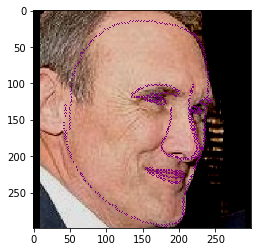

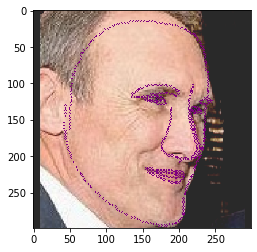

{'brightness': tensor(-0.1247, dtype=torch.float64),
 'contrast': tensor(1.0814, dtype=torch.float64),
 'kernel': tensor(0),
 'scale': tensor(0., dtype=torch.float64),
 'new_w': tensor(0),
 'new_h': tensor(0),
 'x_offset': tensor(0),
 'y_offset': tensor(0),
 'angle': tensor(0., dtype=torch.float64),
 'x_center': tensor(0),
 'y_center': tensor(0)}

time: 15.9 s


In [10]:
with_inv=True

augmenter = RandomAugmentation(
    augmenters_list=[
        Augmenter(with_inv=with_inv),
        BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
        BlurAugmenter(max_kernel=5, with_inv=with_inv),
        CropAugmenter(min_scale=0.8, with_inv=with_inv),
        AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
    ],
    probs=[0.3, 0.2, 0.2, 0.15, 0.15],
#     probs=[0.5, 0.5],
    with_inv=with_inv,
)
# augmenter = BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv)

debug_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    augmenter,
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)), 
])

debug_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), debug_transforms)
debug_dataloader = data.DataLoader(
    debug_dataset, batch_size=100, num_workers=0, #num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)

batch = next(iter(debug_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]


i =  np.random.choice(images.shape[0])
# image = images[i].numpy()
image = tensor_image2numpy(images[i])
landmark = landmarks[i].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample = get_i_from_dict(i, batch)
sample['image'] = tensor_image2numpy(sample['image'])
inv_sample = augmenter.inv(sample)


image = inv_sample['image']
landmark = inv_sample['landmarks'].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample['params']

Посмотрим на пример батча с разными аугментациями

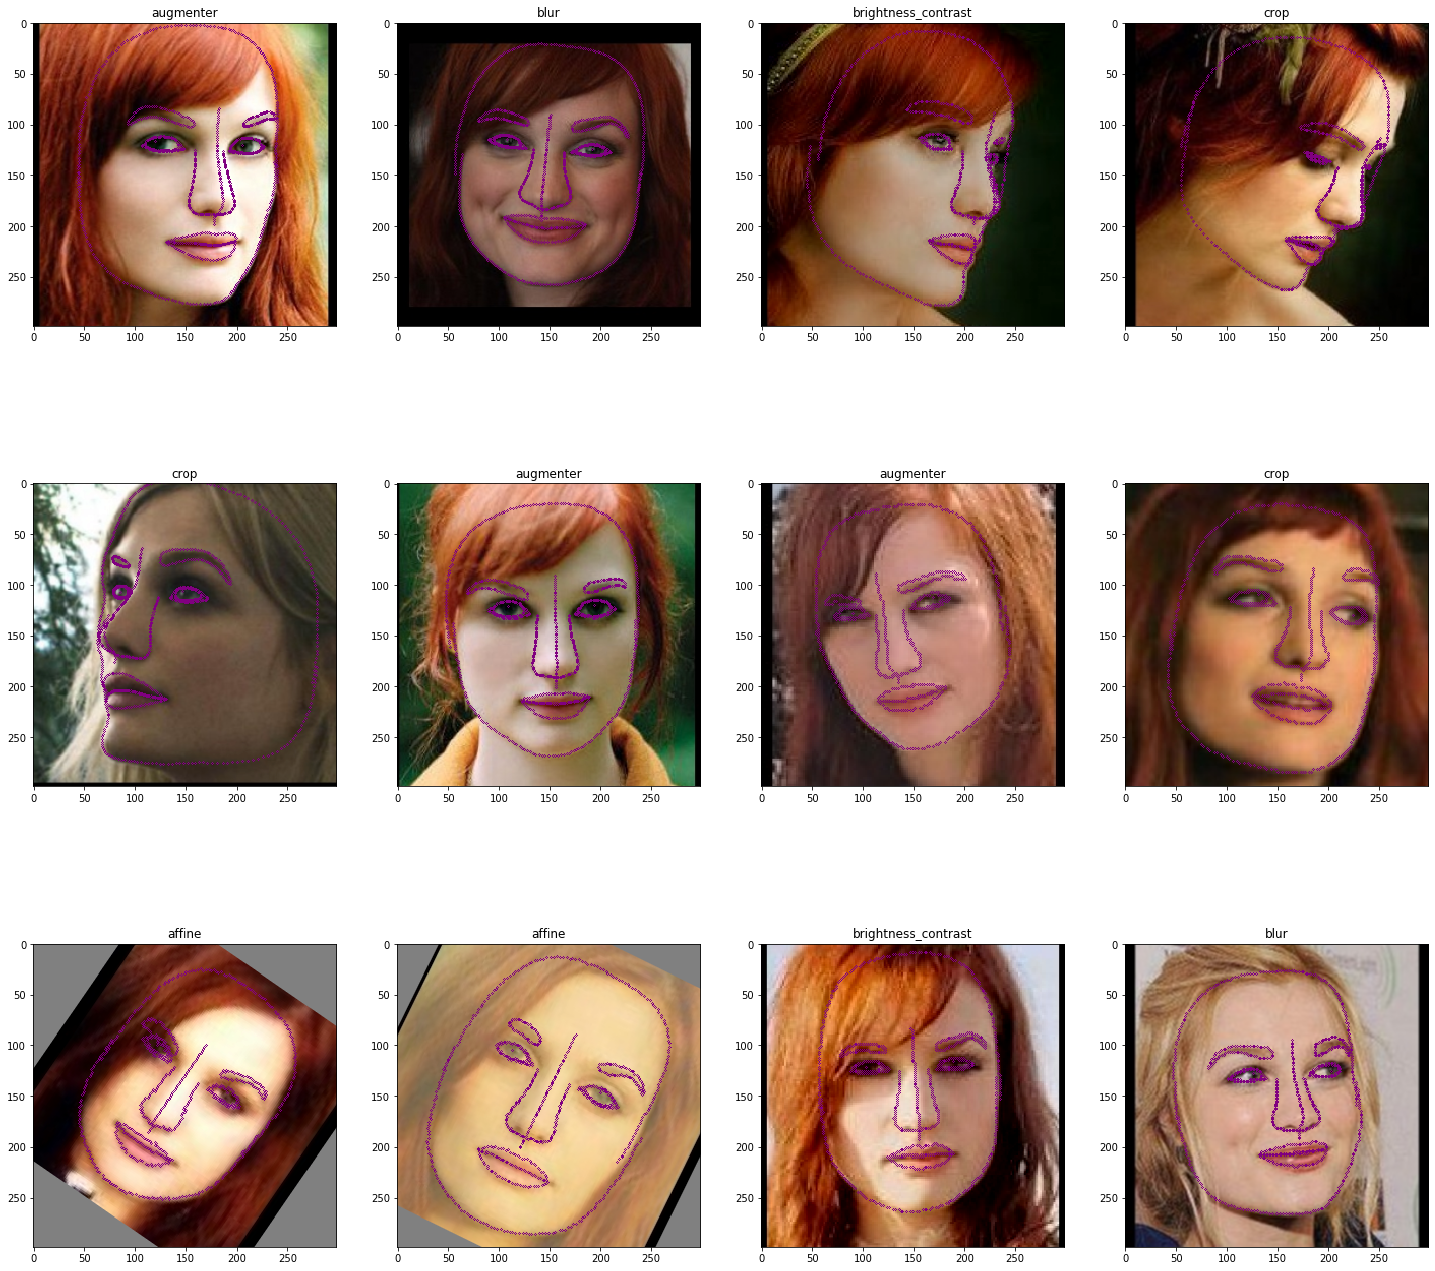

time: 2.19 s


In [11]:
figure_by_samples(list(batch2samples(batch, 12)))
plt.show()

In [12]:
del batch

time: 13.7 ms


### Подготовим данные для обучения

Пайплайн препроцессинга изображений

In [369]:
with_inv = False
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    RandomAugmentation(
        augmenters_list=[
            Augmenter(with_inv=with_inv),
            BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
            BlurAugmenter(max_kernel=5, with_inv=with_inv),
            CropAugmenter(min_scale=0.8, with_inv=with_inv),
            AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
        ],
        probs=[0.3, 0.2, 0.2, 0.15, 0.15],
        with_inv=with_inv,
    ),
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])
val_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])

time: 32.7 ms


Загрузим данные для обучения и валидации

In [13]:
# train_dataset.transforms = train_transforms
# val_dataset.transforms = train_transforms

time: 9.79 ms


In [370]:
train_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(
    train_dataset, batch_size=train_params['batch_size'], num_workers=4, 
    pin_memory=True, shuffle=True, drop_last=True,
)
val_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'train'), val_transforms, split="val")
val_dataloader = data.DataLoader(
    val_dataset, batch_size=train_params['batch_size'], num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)

# train_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms)
# train_dataloader = data.DataLoader(
#     train_dataset, batch_size=10, num_workers=0, #num_workers=4, 
#     pin_memory=True, shuffle=True, drop_last=True,
# )
# val_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), val_transforms)
# val_dataloader = data.DataLoader(
#     val_dataset, batch_size=10, num_workers=0, #num_workers=4, 
#     pin_memory=True, shuffle=False, drop_last=False,
# )









0it [00:00, ?it/s]







52it [00:00, 519.36it/s]







99it [00:00, 475.08it/s]








0it [00:00, ?it/s]







62it [00:00, 377.40it/s]


time: 642 ms


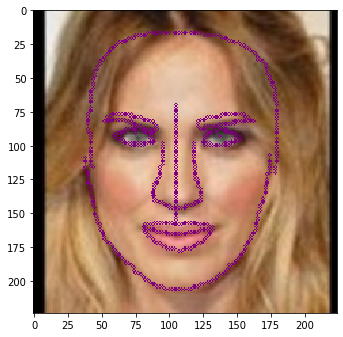

time: 32.2 s


In [15]:
batch = next(iter(val_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]

n_images = 1
idxs = np.random.choice(images.shape[0], size=min(n_images, images.shape[0]), replace=False)
fig = figure_landmark_examples(images=images[idxs], landmarks=landmarks[idxs])
plt.show()

del batch
del images
del landmarks

## Эксперимент

Подберем параметры для lr scheduler и зададим параметры всего эксперимента

n_train_batches: 10, patience: 1


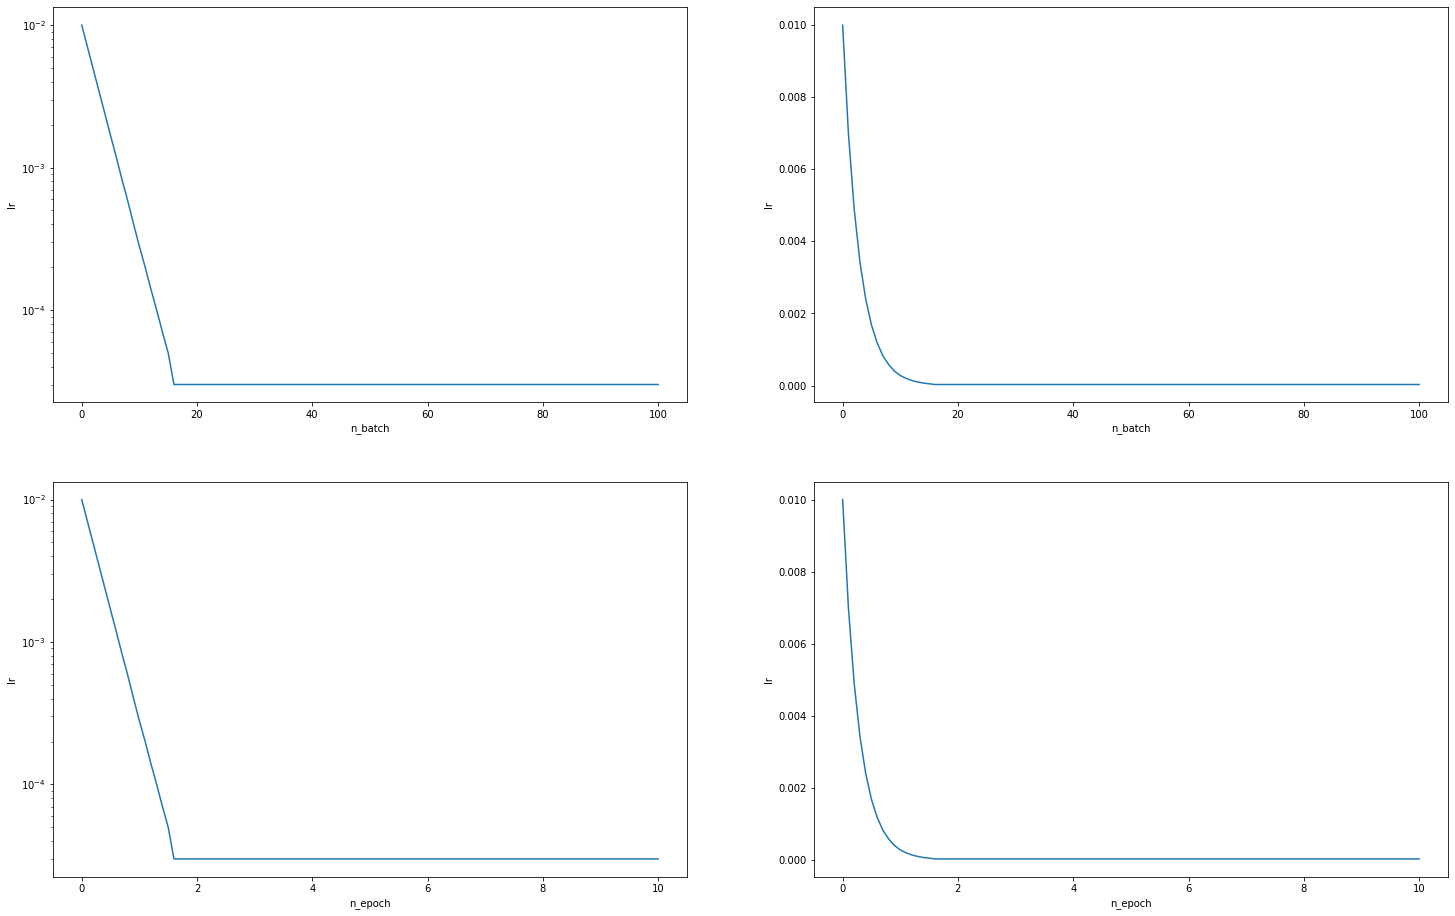

(0.0, 0.01)
(0.1, 0.007)
(0.2, 0.0049)
(0.3, 0.00343)
(0.4, 0.0024)
(0.5, 0.00168)
(0.6, 0.00118)
(0.7, 0.00082)
(0.8, 0.00058)
(0.9, 0.0004)
(1.0, 0.00028)
(1.1, 0.0002)
(1.2, 0.00014)
(1.3, 0.0001)
(1.4, 7e-05)
(1.5, 5e-05)
(1.6, 3e-05)
(1.7, 3e-05)
(1.8, 3e-05)
(1.9, 3e-05)
(2.0, 3e-05)
(2.1, 3e-05)
(2.2, 3e-05)
(2.3, 3e-05)
(2.4, 3e-05)
(2.5, 3e-05)
(2.6, 3e-05)
(2.7, 3e-05)
(2.8, 3e-05)
(2.9, 3e-05)
(3.0, 3e-05)
(3.1, 3e-05)
(3.2, 3e-05)
(3.3, 3e-05)
(3.4, 3e-05)
(3.5, 3e-05)
(3.6, 3e-05)
(3.7, 3e-05)
(3.8, 3e-05)
(3.9, 3e-05)
(4.0, 3e-05)
(4.1, 3e-05)
(4.2, 3e-05)
(4.3, 3e-05)
(4.4, 3e-05)
(4.5, 3e-05)
(4.6, 3e-05)
(4.7, 3e-05)
(4.8, 3e-05)
(4.9, 3e-05)
(5.0, 3e-05)
(5.1, 3e-05)
(5.2, 3e-05)
(5.3, 3e-05)
(5.4, 3e-05)
(5.5, 3e-05)
(5.6, 3e-05)
(5.7, 3e-05)
(5.8, 3e-05)
(5.9, 3e-05)
(6.0, 3e-05)
(6.1, 3e-05)
(6.2, 3e-05)
(6.3, 3e-05)
(6.4, 3e-05)
(6.5, 3e-05)
(6.6, 3e-05)
(6.7, 3e-05)
(6.8, 3e-05)
(6.9, 3e-05)
(7.0, 3e-05)
(7.1, 3e-05)
(7.2, 3e-05)
(7.3, 3e-05)
(7.4, 3e-05)
(7.5, 3

In [400]:
train_params.update({
    'base_model': 'resnet50',
    'epochs': 10,
    'lr': 2e-3,
    'lr_decay': 0.7,
#     'weight_decay': 0.01,
    'weight_decay': 1e-5,
    'gpu': True,
    'top_perc_train': 30.,
    'without_top_perc_train': 1.,
})

n_train_batches = len(train_dataset) // train_params['batch_size']
patience = int(0.1 * n_train_batches)
min_lr = 3e-5
print(f"n_train_batches: {n_train_batches}, patience: {patience}")


lr = train_params['lr']
n_batch = 0
n_batch_lr_pairs = [(n_batch, lr)]
n_epoch_lr_pairs = [(n_batch / n_train_batches, lr)]
while n_batch < n_train_batches * train_params['epochs']:
    lr *= train_params['lr_decay']
    lr = max(lr, min_lr)
    n_batch += patience
    n_batch_lr_pairs.append((n_batch, round(lr, 5)))
    n_epoch_lr_pairs.append((round(n_batch / n_train_batches, 2), round(lr, 5)))

fig = plt.figure(figsize=(25, 2 * 8))

ax = fig.add_subplot(2, 2, 1)
ax.plot(*zip(*n_batch_lr_pairs))
ax.set_xlabel('n_batch')
ax.set_ylabel('lr')
ax.set_yscale("log")

ax = fig.add_subplot(2, 2, 2)
ax.plot(*zip(*n_batch_lr_pairs))
ax.set_xlabel('n_batch')
ax.set_ylabel('lr')

ax = fig.add_subplot(2, 2, 3)
ax.plot(*zip(*n_epoch_lr_pairs))
ax.set_xlabel('n_epoch')
ax.set_ylabel('lr')
ax.set_yscale("log")

ax = fig.add_subplot(2, 2, 4)
ax.plot(*zip(*n_epoch_lr_pairs))
ax.set_xlabel('n_epoch')
ax.set_ylabel('lr')

plt.show()
# fig.show()

print(*n_epoch_lr_pairs, sep='\n')

In [ ]:
exp_name = 'May_04_2020_14:33:50__freeze_model=resnet50_bs=512_epochs=10_lr=0.01_lr_decay=0.7_w_decay=0.0_top_prec=30.0_without_top_perc=1.0'
exp_dir = os.path.join(root_path, 'exp_dirs', exp_name)

device = torch.device("cuda: 0") if train_params['gpu'] else torch.device("cpu")
model = models.resnet50(pretrained=True)

with open(os.path.join(exp_dir, "best_model.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)
    
model.to(device)

Создадим папку под эксперимент

In [401]:
exp_name = get_exp_name(train_params=train_params, name='freeze')
print(exp_name)
exp_dir = os.path.join(root_path, 'exp_dirs', exp_name)
os.makedirs(exp_dir)

May_05_2020_06:09:20__freeze_model=resnet50_bs=10_epochs=10_lr=0.01_lr_decay=0.7_w_decay=1e-05_top_prec=30.0_without_top_perc=1.0
time: 40.4 ms


TensorBoard writer

In [402]:
writer = SummaryWriter(os.path.join(root_path, 'log_dir', exp_name))

time: 31.2 ms


Создадим модель

In [403]:
del model

time: 30.4 ms


device = torch.device("cuda: 0") if train_params['gpu'] else torch.device("cpu")
model = models.resnet50(pretrained=True)#, aux_logits=False)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model.to(device)

In [405]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total_params: {total_params}")
print(f"trainable_params: {trainable_params}({trainable_params / total_params * 100:.2f}%)")

total_params: 27487190
trainable_params: 3979158(14.48%)
time: 29.6 ms


In [406]:
wd = 0.
for p in model.parameters(): 
    wd += (p**2).sum()
wd, wd * train_params['weight_decay']

(tensor(9079.0049, grad_fn=<AddBackward0>),
 tensor(0.0908, grad_fn=<MulBackward0>))

time: 61.1 ms


In [415]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad], 
    lr=train_params['lr'],
    weight_decay=train_params['weight_decay'],
    amsgrad=True,
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=train_params['lr_decay'], patience=patience,
    min_lr=min_lr,
)

# при малых ошибках это MSE, а при больших не хотим сильно реагировать на выбросы(MAE)
# loss_fn = nn.SmoothL1Loss(reduction='none')
loss_fn = ENMELoss(alpha=2.0)

time: 34 ms


Обучим модель

In [416]:
best_val_loss = np.inf
for epoch in range(train_params['epochs']):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, 
                       device=device, epoch=epoch, writer=writer, scheduler=scheduler, 
                       top_perc_train=train_params['top_perc_train'], 
                       without_top_perc_train=train_params['without_top_perc_train'])
    writer.add_scalar('train_loss', train_loss, epoch)

    val_loss = validate(model, val_dataloader, loss_fn, device=device, epoch=epoch, writer=writer)
    writer.add_scalar('val_loss', val_loss, epoch)

    print(f"Epoch #{epoch:2}:\ttrain loss: {train_loss:5.2}\tval loss: {val_loss:5.2}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(exp_dir, "best_model.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

OverflowError: signed integer is less than minimum

<Figure size 1800x1728 with 0 Axes>

time: 21.5 s


~1 час на 1 эпоху обучения resnet50(bs=160), если не заморозить веса

# Предсказание

### Подберем параметры и веса для костантной аугментации



0it [00:00, ?it/s]


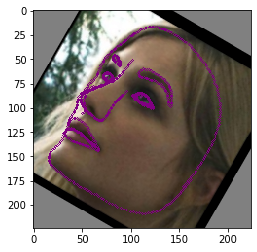

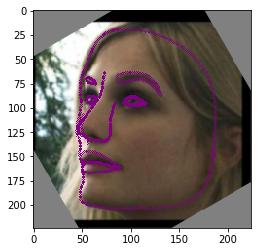

{'angle': tensor(-30., dtype=torch.float64),
 'scale': tensor(1., dtype=torch.float64),
 'x_center': tensor(112),
 'y_center': tensor(112),
 'x_offset': tensor(0),
 'y_offset': tensor(0)}

time: 1.04 s


In [20]:
with_inv=True

# augmenter = RandomAugmentation(
#     augmenters_list=[
#         Augmenter(with_inv=with_inv),
#         BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
#         BlurAugmenter(max_kernel=5, with_inv=with_inv),
#         CropAugmenter(min_scale=0.8, with_inv=with_inv),
#         AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv),
#     ],
#     probs=[0.3, 0.2, 0.2, 0.15, 0.15],
# #     probs=[0.5, 0.5],
#     with_inv=with_inv,
# )
augmenter = AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.01, rotate=True, with_inv=with_inv)
const_params_dict = dict(angle=-30., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0)
augmenter = constant_augmenter(augmenter, const_params_dict)

debug_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    augmenter,
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)), 
])

debug_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), debug_transforms, n_samples=10)
debug_dataloader = data.DataLoader(
    debug_dataset, batch_size=10, num_workers=0, #num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)

batch = next(iter(debug_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]


i =  np.random.choice(images.shape[0])
# image = images[i].numpy()
image = tensor_image2numpy(images[i])
landmark = landmarks[i].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample = get_i_from_dict(i, batch)
sample['image'] = tensor_image2numpy(sample['image'])
inv_sample = augmenter.inv(sample)


image = inv_sample['image']
landmark = inv_sample['landmarks'].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

del batch
del images
del landmarks
sample['params']

In [417]:
with_inv = True
augmenter_params_weigth = [
    (Augmenter(with_inv=with_inv), 
     dict(),
     0.3,
    ),
    
    
    # обычно увеличение яркости и контраста улучшает изображение
    (BrightnessContrastAugmenter(with_inv=with_inv), 
     dict(brightness=0.1, contrast=1.2),
     0.2,
    ),
    
    # небольшая обрезка краев изображения(лицо становится крупней)
    (CropAugmenter(with_inv=with_inv), 
     dict(
            scale=0.9, 
            new_w=int(CROP_SIZE*0.9), new_h=int(CROP_SIZE*0.9), 
            x_offset=int(CROP_SIZE*0.05), y_offset=int(CROP_SIZE*0.05),
     ),
     0.15,
    ),
    
    
    # повороты на +/- 10, 20 градусов
    (AffineAugmenter(with_inv=with_inv), 
     dict(angle=10., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
     0.1,
    ),
    (AffineAugmenter(with_inv=with_inv), 
     dict(angle=-10., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
     0.1,
    ),
    (AffineAugmenter(with_inv=with_inv), 
     dict(angle=20., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
     0.05,
    ),
    (AffineAugmenter(with_inv=with_inv), 
     dict(angle=-20., scale=1.0, x_center=CROP_SIZE//2, y_center=CROP_SIZE//2, x_offset=0, y_offset=0),
     0.05,
    ),
   
    # это скорее ухудшает, но мало ли)))
    (BlurAugmenter(with_inv=with_inv),
     dict(kernel=3),
     0.05,
    ),
]

time: 152 ms


In [419]:
transforms_weight = []
sum_weight = 0
for augmenter, params, weight in augmenter_params_weigth:
    augmenter = constant_augmenter(augmenter, params)

    test_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        augmenter,

        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225],
        ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
    ])
    
    transforms_weight.append((test_transforms, weight))
    sum_weight += weight

assert sum_weight == 1

time: 32.2 ms


Для обратного преобразовения предсказаний

In [420]:
augmenter_classes = [Augmenter, AffineAugmenter, CropAugmenter, BrightnessContrastAugmenter, BlurAugmenter]
augmenter_name2class = {
    class_.name: class_
    for class_ in augmenter_classes
}

time: 31.9 ms


Загрузим тестовые данные

In [421]:
# test_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'test'), train_transforms, split="test")
test_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'test'), val_transforms, split='test')











0it [00:00, ?it/s]

time: 46.6 ms


In [424]:
def predict(model, loader, device):
    model.eval()
    
    not_restored_predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))          
    choose_augmenter = True

    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        if choose_augmenter:
            augmenter = augmenter_name2class[batch['augmenter'][0]]()
            print(augmenter.name)
            choose_augmenter = False

        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()

        # обратно конвертнуть
        batch["landmarks"] = pred_landmarks
        samples = batch2samples(batch=batch, size=pred_landmarks.shape[0])
        inv_samples = [augmenter.inv(sample) for sample in samples]
        inv_batch = loader.collate_fn(inv_samples)
        pred_landmarks = inv_batch["landmarks"]


        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        not_restored_predictions[i * loader.batch_size: (i + 1) * loader.batch_size] += pred_landmarks * weight

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] += prediction * weight

    return predictions, not_restored_predictions

time: 36 ms


In [423]:
with open(os.path.join(exp_dir, "best_model.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

FileNotFoundError: [Errno 2] No such file or directory: './exp_dirs/May_05_2020_06:09:20__freeze_model=resnet50_bs=10_epochs=10_lr=0.01_lr_decay=0.7_w_decay=1e-05_top_prec=30.0_without_top_perc=1.0/best_model.pth'

time: 40.5 ms


In [426]:
sum_weight = 0
test_predictions = np.zeros((len(test_dataset), NUM_PTS, 2))
test_not_restored_predictions = np.zeros((len(test_dataset), NUM_PTS, 2))

for t, weight in transforms_weight:
    test_dataset.transforms = t
    test_loader = data.DataLoader(
        test_dataset, batch_size=train_params['batch_size'], num_workers=4, 
        pin_memory=True, shuffle=False, drop_last=False,
    )

    predictions, not_restored_predictions = predict(model, test_loader, device)
    
    if sum_weight == 0:
        test_predictions = predictions * weight
        test_not_restored_predictions = not_restored_predictions * weight
    else:
        test_predictions = test_predictions * sum_weight + predictions * weight
        test_not_restored_predictions = test_not_restored_predictions * sum_weight + not_restored_predictions * weight
    
    sum_weight += weight
    test_predictions /= sum_weight
    test_not_restored_predictions /= sum_weight
    
    with open(os.path.join(exp_dir, f"test_predictions_{sum_weight:.2f}.pkl"), "wb") as fp:
        pickle.dump({
                "image_names": test_dataset.image_names,
                "landmarks": test_predictions
            }, 
            fp,
        )
        
    create_submission(data_dir, test_predictions, os.path.join(exp_dir, f"submit_{sum_weight:.2f}.csv"))

augmenter



IndexError: index 100 is out of bounds for axis 0 with size 100

time: 14.5 s


In [34]:
create_submission(data_dir, test_predictions, os.path.join(exp_dir, "submit.csv"))

time: 21.2 s


Посмотрим на итоговые предсказания

In [35]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
#     augmenter,

    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])

test_dataset.transforms = test_transforms

time: 12.4 ms


In [428]:
n_images = 8
idxs = np.random.choice(len(test_dataset), size=n_images, replace=False)

images = val_dataloader.collate_fn([test_dataset[idx] for idx in idxs])["image"]

model.eval()
with torch.no_grad():
    images = images.to(device)
    simple_pred_landmarks = model(images).cpu()

images = images.cpu()
fig = figure_landmark_examples(images=images, landmarks=test_not_restored_predictions[idxs], landmarks2=simple_pred_landmarks)
plt.show()

OverflowError: signed integer is less than minimum

<Figure size 1800x2304 with 0 Axes>

time: 2.12 s


Оценим, какое примерно, отличие в итоговом MSE даст такое "ансамблирование" аугментациями

In [37]:
np.sum(
    (test_not_restored_predictions[idxs].reshape(-1) - np.array(simple_pred_landmarks).reshape(-1))**2
) / simple_pred_landmarks.shape[0] / NUM_PTS

1.3198241017080016e-09

time: 18.3 ms
